In [230]:
import sys
import re
from os import walk
from pathlib import Path
from functools import reduce

In [231]:
ROOT_PATH = "/Users/janschill/code/rails/rails"

In [232]:
def full_path(file_name):
    return ROOT_PATH + file_name

In [233]:
# Number of lines
def LOC(file):
    return sum([1 for line in open(file)])

In [234]:
def extract_from_line(name, line):
    if re.search("^([\s]*#)", line): # ignore comments
        return None
    elif name == 'module|class|end':
        namespace = re.search("^([\s]*(module|class|end)[ (\S+)]*)", line)
        return str(namespace.group(1)) if namespace else None
    else:
        x = re.search("" + name + " (\S+)", line)
        return None if x == None else str(x.group(1))

In [235]:
# Number of methods
def number_of(file, key_word):
    return sum([1 for line in open(file) if extract_from_line(key_word, line)])

def extract(file, key_word):
    extracts = []
    for line in open(file):
        extract = extract_from_line(key_word, line)
        if extract:
            extracts.append(extract)
    return extracts

def extract_requires(file):
    return extract(file, 'requires')

def extract_module(file):
    return extract(file, 'module')

def extract_class(file):
    return extract(file, 'class')

def clean_namespace(namespace):
    return namespace.replace('module', '').replace('class', '').replace(' ', '')

def extract_namespace(file):
    namespaces = []
    namespace = []
    previous_identation = -1
    for line in open(file):
        extract = extract_from_line('module|class|end', line)
        if extract == None:
            continue
        else:
            if 'end' in extract and (len(extract) - len(extract.lstrip(' ')) == previous_identation):
                namespaces.append(namespace.copy())
            elif 'module' in extract or 'class' in extract:
                current_identation = len(extract) - len(extract.lstrip(' '))
                module_or_class = 'module' if 'module' in extract else 'class'
                current_namespace = clean_namespace(extract)    
                if current_identation > previous_identation:
                    namespace.append(current_namespace)
                elif current_identation < previous_identation:
                    del namespace[-1]
                    if len(namespace) > 0:
                        del namespace[-1]
                    namespace.append(current_namespace)
                else:
                    del namespace[-1]
                    namespace.append(current_namespace)
                previous_identation = current_identation
            else:
                continue
    return namespaces

In [237]:
def number_of_modules(file):
    return number_of(file, 'module')

def number_of_methods(file):
    return number_of(file, 'def')

def number_of_requires(file):
    return number_of(file, 'require')

In [238]:
directories = []
for (dirpath, dirnames, filenames) in walk(ROOT_PATH):
    directories.extend(dirnames)
    break
directories = list(filter(lambda x: x[0] != ".", directories)) # don't use hidden dirs

In [239]:
def get_files(path, file_extension):
    files = Path(path).rglob("*." + file_extension)
    meta_data_files = []
    for file in files:
        meta_data_files.append({
            'filename': str(file),
            'LOC': LOC(file),
            'no_modules': number_of_modules(file),
            'no_methods': number_of_methods(file),
            'no_requires': len(extract_requires(file)),
            'requires': extract_requires(file),
            'namespace': extract_namespace(file)
        })
    return meta_data_files

In [240]:
def reduce_by_key(list, key):
    sum = 0
    for el in list:
        sum = sum + el[key]
    return sum

In [241]:
rails_modules = {}
for directory in directories:
    files = get_files(full_path('/' + directory + '/'), 'rb')
    average_LOC = int(reduce_by_key(files, 'LOC') / len(files))
    average_NOM = int(reduce_by_key(files, 'no_methods') / len(files))
    average_requires = int(reduce_by_key(files, 'no_requires') / len(files))
    rails_modules[directory] = {
        'files': files,
        'average LOC': average_LOC ,
        'average NOM': average_NOM,
        'average requires': average_requires }
rails_modules = {k: v for k, v in sorted(rails_modules.items(), key = lambda item: item[0])}

In [242]:
from tabulate import tabulate
format = "{:<15}{:<1}{:<10}{:<1}{:<7}{:<1}{:<10}{:<1}{:<10}"
print(format.format("Module", " | ", "Ruby files", " | ", "Ø LOC", " | ", "Ø Methods", " | ", "Ø Requires"))
print('----------------+------------+---------+------------+-----------')
for k, v in rails_modules.items():
    print(format.format(k, ' | ' , len(v['files']), ' | ', v['average LOC'], ' | ', v['average NOM'], ' | ', v['average requires']))

Module          | Ruby files | Ø LOC   | Ø Methods  | Ø Requires
----------------+------------+---------+------------+-----------
actioncable     | 86         | 79      | 6          | 0         
actionmailbox   | 93         | 34      | 1          | 0         
actionmailer    | 41         | 140     | 9          | 0         
actionpack      | 325        | 202     | 16         | 0         
actiontext      | 74         | 35      | 2          | 0         
actionview      | 186        | 231     | 18         | 0         
activejob       | 118        | 70      | 4          | 0         
activemodel     | 130        | 118     | 8          | 0         
activerecord    | 853        | 160     | 12         | 0         
activestorage   | 124        | 62      | 3          | 0         
activesupport   | 469        | 119     | 10         | 0         
ci              | 1          | 22      | 0          | 0         
guides          | 22         | 69      | 3          | 0         
railties        | 278    

# Lines of code

In [324]:
def rails_loc():
    RAILS_LOC = 0
    for k,v in rails_modules.items():
        for file in v['files']:
            RAILS_LOC += file['LOC']
    return RAILS_LOC

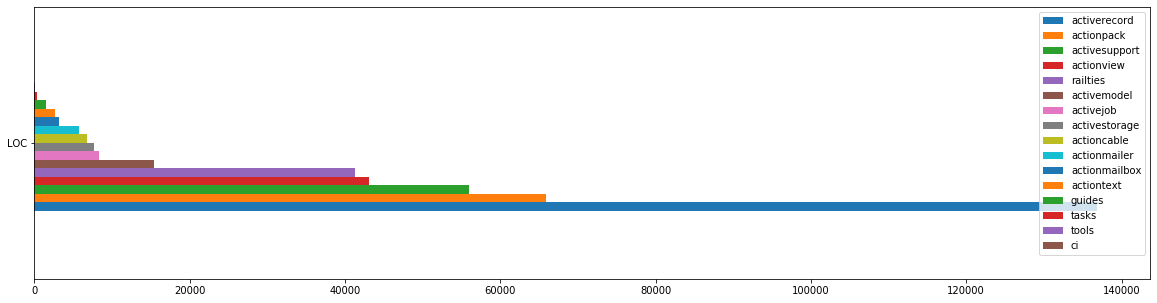

In [377]:
import pandas as pd
RAILS_LOC = rails_loc()
modules_loc = {}
for k,v in rails_modules.items():
    modules_loc[k] = 0
    for file in v['files']:
        modules_loc[k] += file['LOC']
    rails_modules[k]['LOC'] = modules_loc[k]
modules_loc = {k: v for k, v in sorted(modules_loc.items(), key=lambda item: item[1], reverse=True)}
df = pd.DataFrame(modules_loc, index=['LOC'])
ax = df.plot.barh(figsize=(20,5))

In [378]:
format = "{:<15}{:<1}{:<5}"
print(format.format('Module', ' | ', 'LOC'))
print('----------------+-------')
for k, v in modules_loc.items():
    print(format.format(k, ' | ' , v))

Module          | LOC  
----------------+-------
activerecord    | 136860
actionpack      | 65919
activesupport   | 56011
actionview      | 43045
railties        | 41328
activemodel     | 15441
activejob       | 8265 
activestorage   | 7710 
actioncable     | 6846 
actionmailer    | 5742 
actionmailbox   | 3170 
actiontext      | 2625 
guides          | 1534 
tasks           | 323  
tools           | 43   
ci              | 22   


In [353]:
def get_filename(path):
    return os.path.basename(os.path.normpath(path)).replace('.rb', '')

In [381]:
format = "{:<35}{:<1}{:<7}{:<1}"
print(format.format('Module', ' | ', 'LOC', '|'))
print('------------------------------------+-------|')
for k, v in rails_modules.items():
    print(format.format(k, ' | ', rails_modules[k]['LOC'], ' | '))
    print('------------------------------------+-------|')
    files = sorted(v['files'], key=lambda k: k['LOC'], reverse=True)
    for f in files:
        print(format.format(get_filename(f['filename']), ' | ', f['LOC'], ' | '))
    print('------------------------------------+-------|')

Module                              | LOC    
------------------------------------+-------
actioncable                         | 6846   
------------------------------------+-------
stream_test                         | 372    
client_test                         | 314    
test_case                           | 310    
base_test                           | 282    
base                                | 266    
test_case                           | 234    
base                                | 222    
test_case_test                      | 214    
streams                             | 202    
test_case_test                      | 197    
redis                               | 180    
client_socket                       | 157    
subscriptions_test                  | 149    
base_test                           | 143    
stream_event_loop                   | 136    
test_helper                         | 133    
postgresql                          | 133    
common                              

In [282]:
def remove_root_path(path):
    return path.replace(ROOT_PATH + '/', '')

def remove_module_path(path, module):
    return path.replace(module, '')

def remove_filename(path):
    return path.replace(os.path.basename(os.path.normpath(path)), '')

def get_relative_path(path, module):
    return remove_module_path(remove_root_path(remove_filename(path)), module)

def get_filename(path):
    return os.path.basename(os.path.normpath(path)).replace('.rb', '')

In [311]:
format = "{:<55}{:<1}{:<4}{:<1}{:<50}{:<1}{:<50}"
for k, v in rails_modules.items():
    print(format.format(k, ' | ', 'LOC', ' | ', 'Path', ' | ', 'Namespaces'))
    print('--------------------------------------------------------+------------+---------+------------+-----------')
    for f in v['files']:
        namesspaces = ''.join("\n".join(e) for e in f['namespace'])
        print(format.format(get_filename(f['filename']), ' | ', f['LOC'], ' | ', get_relative_path(f['filename'], k), ' | ', ''))

    print()
    print('===================================')
    print()

actioncable                                             | LOC  | Path                                               | Namespaces                                        
--------------------------------------------------------+------------+---------+------------+-----------
client_test                                             | 314  | /test/                                             |                                                   
javascript_package_test                                 | 13   | /test/                                             |                                                   
worker_test                                             | 46   | /test/                                             |                                                   
test_helper_test                                        | 116  | /test/                                             |                                                   
test_helper                                       

In [243]:
# ActionCable
action_cable = rails_modules['actioncable']
action_cable['files'][22]

{'filename': '/Users/janschill/code/rails/rails/actioncable/test/subscription_adapter/subscriber_map_test.rb',
 'LOC': 19,
 'no_modules': 0,
 'no_methods': 1,
 'no_requires': 0,
 'requires': [],
 'namespace': [['SubscriberMapTest<ActionCable::TestCase']]}